# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset

In [2]:
activity1 = pd.concat([
    pd.read_csv('../../shared_data/round1/prices_round_1_day_-2.csv', sep=';'),
    pd.read_csv('../../shared_data/round1/prices_round_1_day_-1.csv', sep=';'),
    pd.read_csv('../../shared_data/round1/prices_round_1_day_0.csv', sep=';')
])
activity3 = pd.concat([
    pd.read_csv('../../shared_data/round3/prices_round_3_day_0.csv', sep=';'),
    pd.read_csv('../../shared_data/round3/prices_round_3_day_1.csv', sep=';'),
    pd.read_csv('../../shared_data/round3/prices_round_3_day_2.csv', sep=';')
])
activity4 = pd.concat([
    pd.read_csv('../../shared_data/round4/prices_round_4_day_1.csv', sep=';'),
    pd.read_csv('../../shared_data/round4/prices_round_4_day_2.csv', sep=';'),
    pd.read_csv('../../shared_data/round4/prices_round_4_day_3.csv', sep=';')
])
trade1 = pd.concat([
    pd.read_csv('../../shared_data/round5/trades_round_1_day_-2_wn.csv', sep=';').assign(day=-2),
    pd.read_csv('../../shared_data/round5/trades_round_1_day_-1_wn.csv', sep=';').assign(day=-1),
    pd.read_csv('../../shared_data/round5/trades_round_1_day_0_wn.csv', sep=';').assign(day=0)
])
trade3 = pd.concat([
    pd.read_csv('../../shared_data/round5/trades_round_3_day_0_wn.csv', sep=';').assign(day=0),
    pd.read_csv('../../shared_data/round5/trades_round_3_day_1_wn.csv', sep=';').assign(day=1),
    pd.read_csv('../../shared_data/round5/trades_round_3_day_2_wn.csv', sep=';').assign(day=2)
])
trade4 = pd.concat([
    pd.read_csv('../../shared_data/round5/trades_round_4_day_1_wn.csv', sep=';').assign(day=1),
    pd.read_csv('../../shared_data/round5/trades_round_4_day_2_wn.csv', sep=';').assign(day=2),
    pd.read_csv('../../shared_data/round5/trades_round_4_day_3_wn.csv', sep=';').assign(day=3)
])

for a in [activity1, activity3, activity4]:
    a.set_index(['product', 'day', 'timestamp'], inplace=True)
    a.sort_index(inplace=True)

for t in [trade1, trade3, trade4]:
    t.set_index(['symbol', 'day', 'timestamp'], inplace=True)
    t.sort_index(inplace=True)

In [3]:
trade = pd.concat([trade1, trade3, trade4])
traders = trade['buyer'].unique()
traders.sort()
traders

array(['Adam', 'Amelia', 'Raj', 'Remy', 'Rhianna', 'Ruby', 'Valentina',
       'Vinnie', 'Vladimir'], dtype=object)

# Round 1

In [52]:
def plot_trade_on_price(sample, product, activity, trade, markersize=8):
    days = trade.index.get_level_values('day').unique().sort_values()
    
    for person in traders:
        for d in days:
            a = activity.loc[product, d, sample].droplevel([0, 1])
            t = trade.loc[product, d, sample].droplevel([0, 1])        
            buy_trade = t[t['buyer'] == person]
            sell_trade = t[t['seller'] == person]

            if buy_trade.empty and sell_trade.empty:
                continue
            
            position = buy_trade['quantity'].sum() - sell_trade['quantity'].sum()
            profit1 = -buy_trade['price'] @ buy_trade['quantity'] + sell_trade['price'] @ sell_trade['quantity']
            profit2 = position * a['bid_price_1'].iloc[-1] if position > 0 else position * a['ask_price_1'].iloc[-1]
            
            fig, ax = plt.subplots(figsize=(18, 6))
            ax.plot(a['bid_price_1'], label='bid_price_1', alpha=0.1)
            ax.plot(a['ask_price_1'], label='ask_price_1', alpha=0.1)
            ax.plot(a['mid_price'], label='mid_price', alpha=0.2)
            buy_trade['price'].plot(ax=ax, style='^', color='red', label='buy', markersize=markersize, alpha=0.5)
            sell_trade['price'].plot(ax=ax, style='v', color='green', label='sell', markersize=markersize, alpha=0.5)
            ax.legend()
            ax.set_title(f'Round 1, day {d}, {product}, {person}: position {position}, profit1 {profit1}, profit2 {profit2}, total profit {profit1 + profit2}')

            plt.show()

def get_trade_profit(trade, activity):
    days = trade.index.get_level_values('day').unique().sort_values()
    products = trade.index.get_level_values('symbol').unique().sort_values()
    traders = trade['buyer'].unique()
    profit = []

    for d in days:
        profit_day = pd.DataFrame(index=traders, columns=products)
        for person in traders:        
            for product in products:
                a = activity.loc[product, d].sort_index()
                t = trade.loc[product, d].sort_index()
                buy_trade = t[t['buyer'] == person]
                sell_trade = t[t['seller'] == person]

                if buy_trade.empty and sell_trade.empty:
                    profit_day.loc[person, product] = 0

                position = buy_trade['quantity'].sum() - sell_trade['quantity'].sum()
                profit1 = -buy_trade['price'] @ buy_trade['quantity'] + sell_trade['price'] @ sell_trade['quantity']
                profit2 = position * a['bid_price_1'].iloc[-1] if position > 0 else position * a['ask_price_1'].iloc[-1]
                profit_day.loc[person, product] = profit1 + profit2
        profit.append(profit_day.assign(day=d).set_index('day', append=True))

    profit = pd.concat(profit).sort_index()
    return profit

In [56]:
get_trade_profit(trade1, activity1)

symbol        AMETHYSTS STARFRUIT
          day                    
Adam      -2     -722.0   -5488.0
          -1     -708.0   -3469.0
           0     -610.0    -164.0
Amelia    -2    -3709.0   -4021.0
          -1    -4850.0   -4547.0
           0    -3449.0   -8878.0
Remy      -2    -4819.0  -18341.0
          -1    -4484.0   -3908.0
           0    -4455.0   -5846.0
Rhianna   -2    -2690.0   -6504.0
          -1    -2242.0    -564.0
           0    -2522.0    -688.0
Ruby      -2    -4251.0   -7953.0
          -1    -4743.0   -9435.0
           0    -4338.0   -2312.0
Valentina -2     9699.0   49581.0
          -1    10439.0   13115.0
           0     9352.0   10389.0
Vinnie    -2     3140.0  -10546.0
          -1     2802.0    3933.0
           0     3148.0    2243.0
Vladimir  -2     2120.0     881.0
          -1     2074.0    1965.0
           0     1642.0    1986.0

In [54]:
get_trade_profit(trade3, activity3)

symbol       CHOCOLATE GIFT_BASKET    ROSES STRAWBERRIES
         day                                            
Remy     0      3045.0         0.0 -12369.0      -7247.0
         1     -6187.0         0.0  -8615.0      -1538.0
         2     10735.0         0.0    333.0       -779.0
Rhianna  0         0.0     25236.0   1857.0          0.0
         1         0.0     46332.0    720.0          0.0
         2         0.0    175355.0    807.0          0.0
Ruby     0         0.0      -207.0      0.0          0.0
         1         0.0     -2795.0      0.0          0.0
         2         0.0      7333.0      0.0          0.0
Vinnie   0    -44502.0     -7105.0 -67104.0      39450.0
         1    -42320.0     14915.0 -71656.0     -48643.0
         2    -80651.0    -29515.0  67415.0     -65062.0
Vladimir 0     38229.0    -21466.0  76907.0     -35158.0
         1     47126.0    -61260.0  78824.0      44077.0
         2     66232.0   -156643.0 -69257.0      62835.0

In [55]:
get_trade_profit(trade4, activity4)

symbol        COCONUT COCONUT_COUPON
          day                       
Raj       1    2252.0            0.0
          2    2066.0            0.0
          3   -2305.0            0.0
Rhianna   1    -455.0       -29245.0
          2     551.0        65356.0
          3     365.0         7376.0
Ruby      1       0.0        13781.0
          2       0.0        12032.0
          3       0.0         2852.0
Valentina 1       0.0       190521.0
          2       0.0      -442865.0
          3       0.0       -36550.0
Vinnie    1   -1845.0      -194342.0
          2   -2711.0       366699.0
          3    1868.0        19166.0
Vladimir  1       0.0        10752.0
          2       0.0       -10298.0
          3       0.0        -1808.0

## AMETHYSTS

In [ ]:
product = 'AMETHYSTS'
sample = slice(0,1_000_000)

plot_trade_on_price(sample, product, activity1, trade1)

In [ ]:
trade1.loc[product].groupby('buyer')['price'].describe()

In [ ]:
trade1.loc[product].groupby('seller')['price'].describe()

## STARFRUIT

In [ ]:
product = 'STARFRUIT'
sample = slice(0,1_000_000)

plot_trade_on_price(sample, product, activity1, trade1)

# Round 3

## GIFT_BASKET

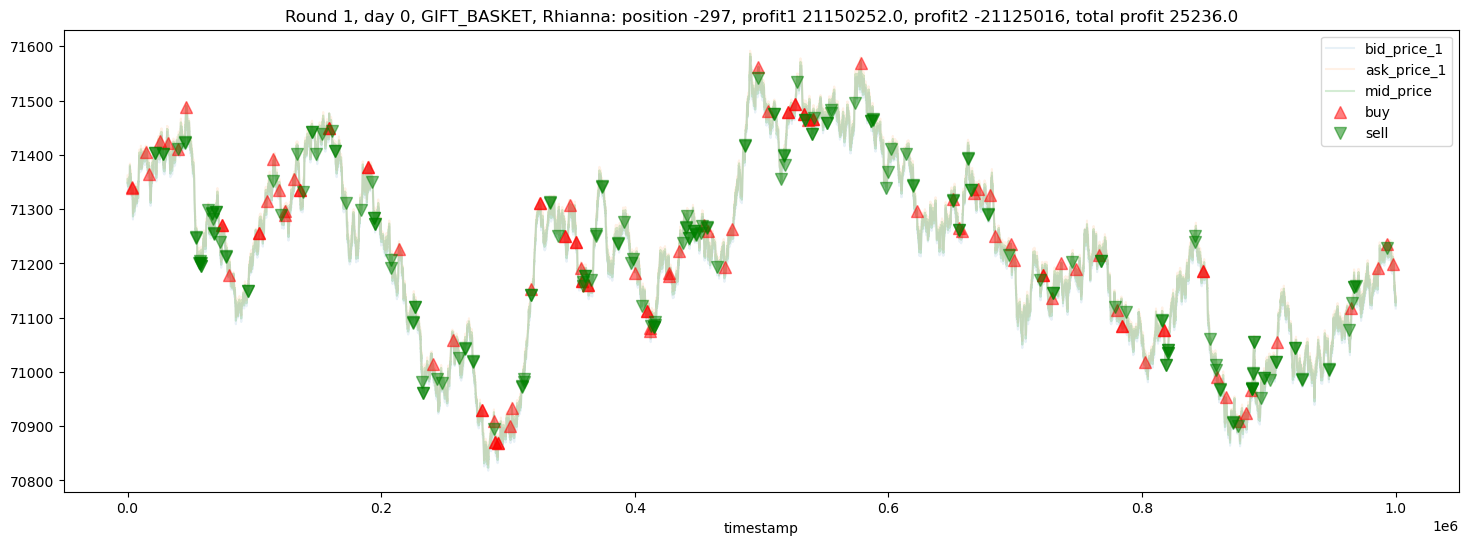

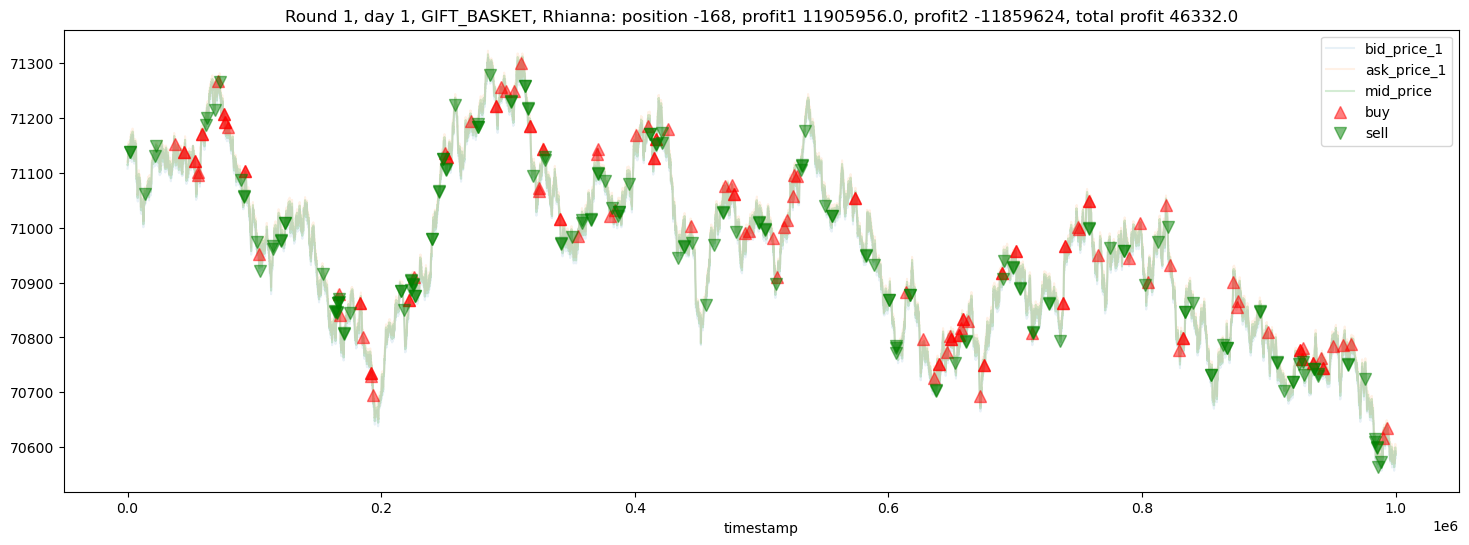

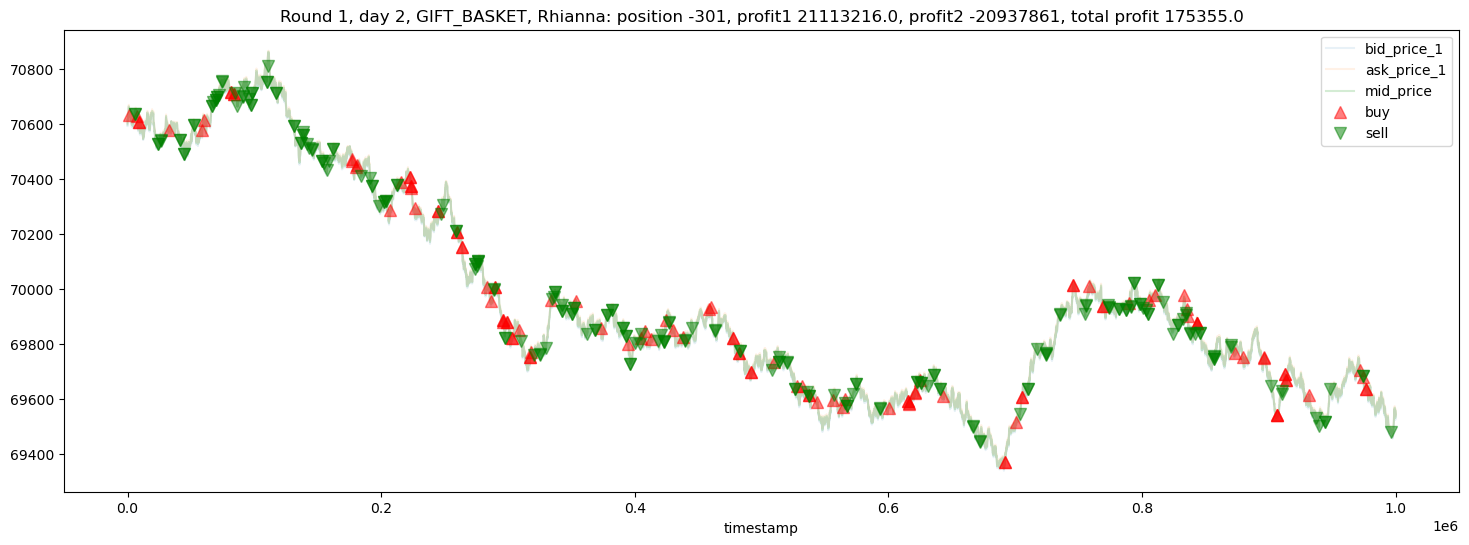

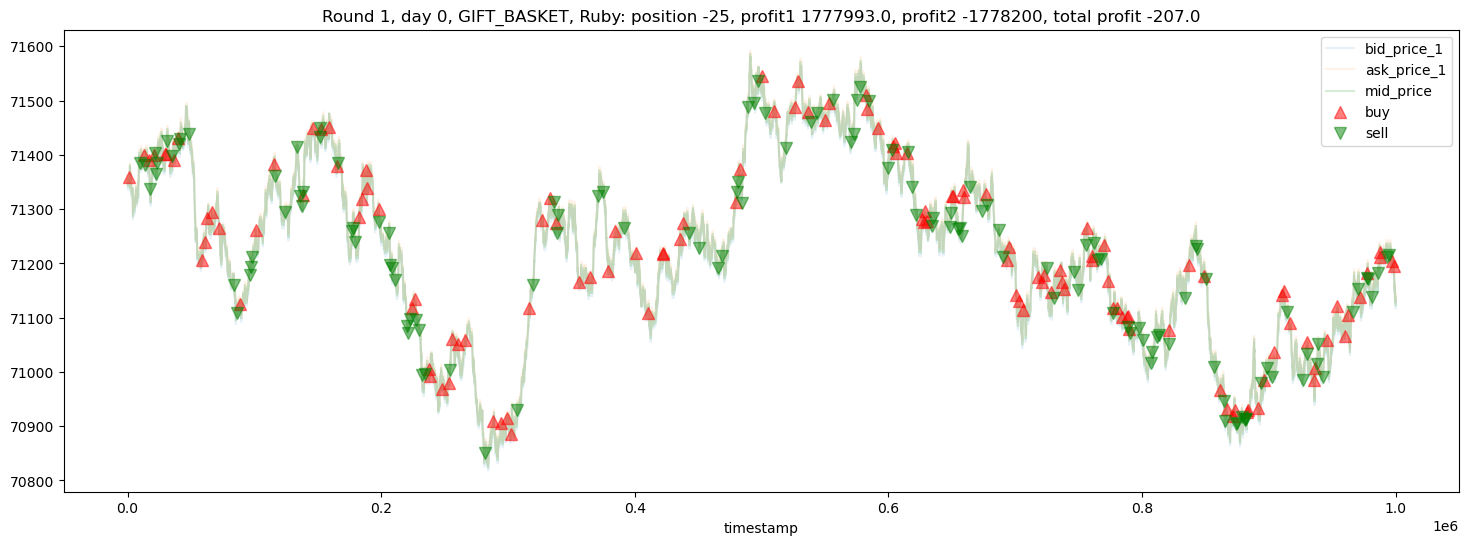

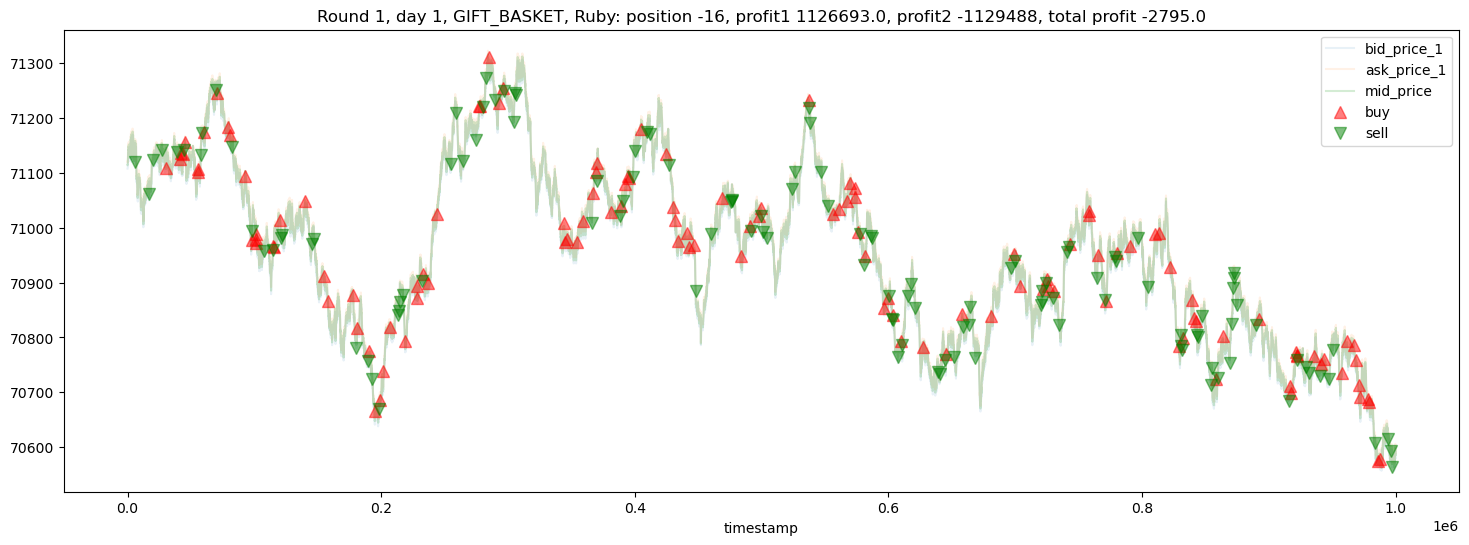

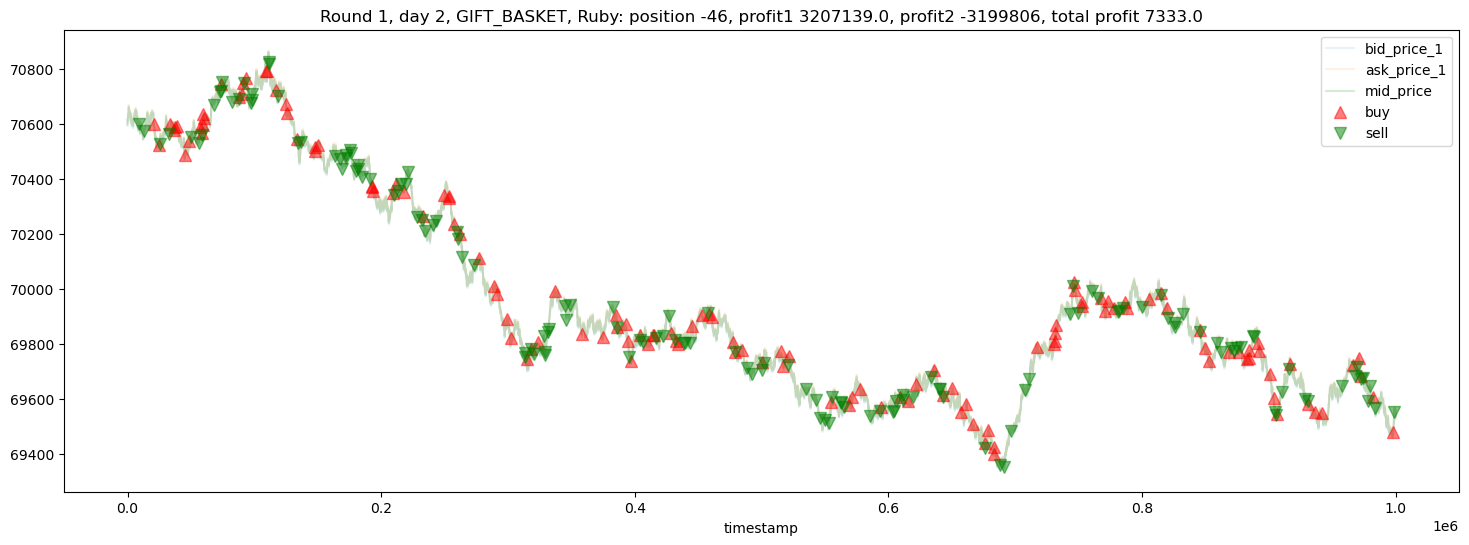

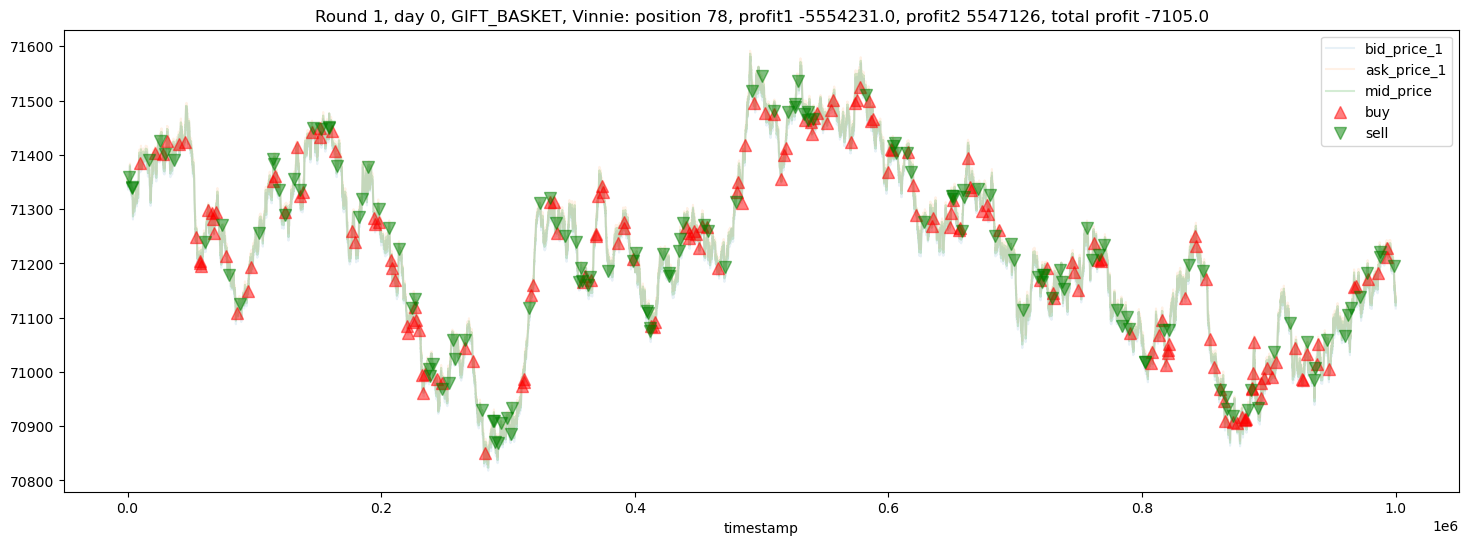

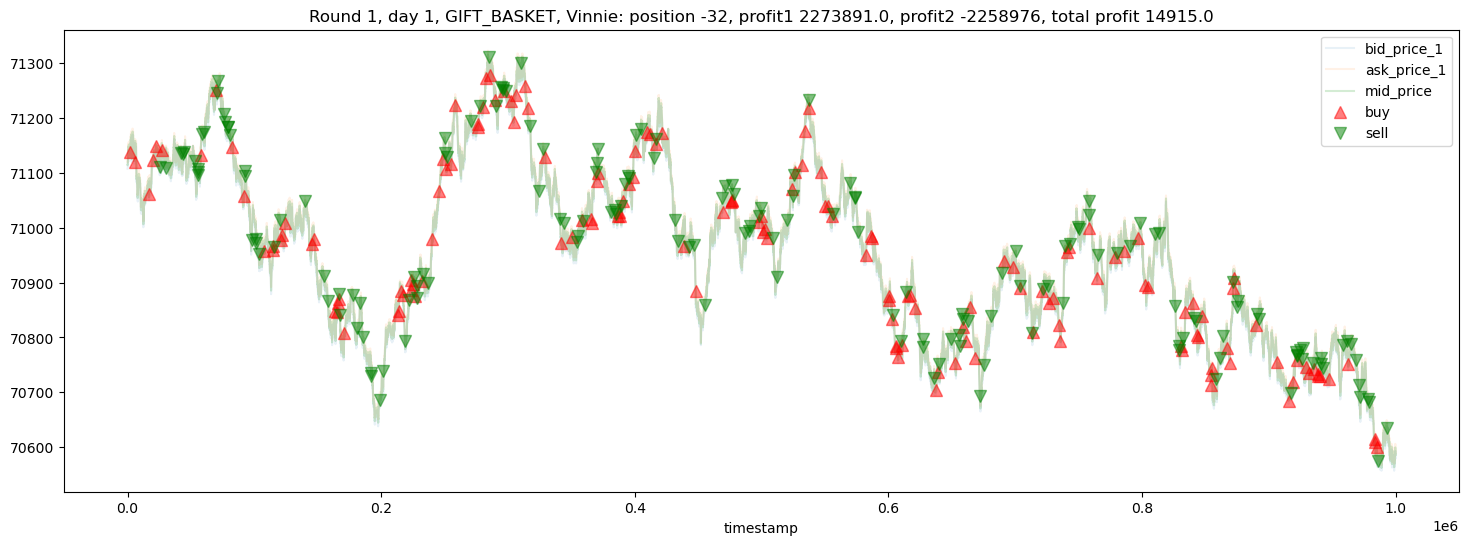

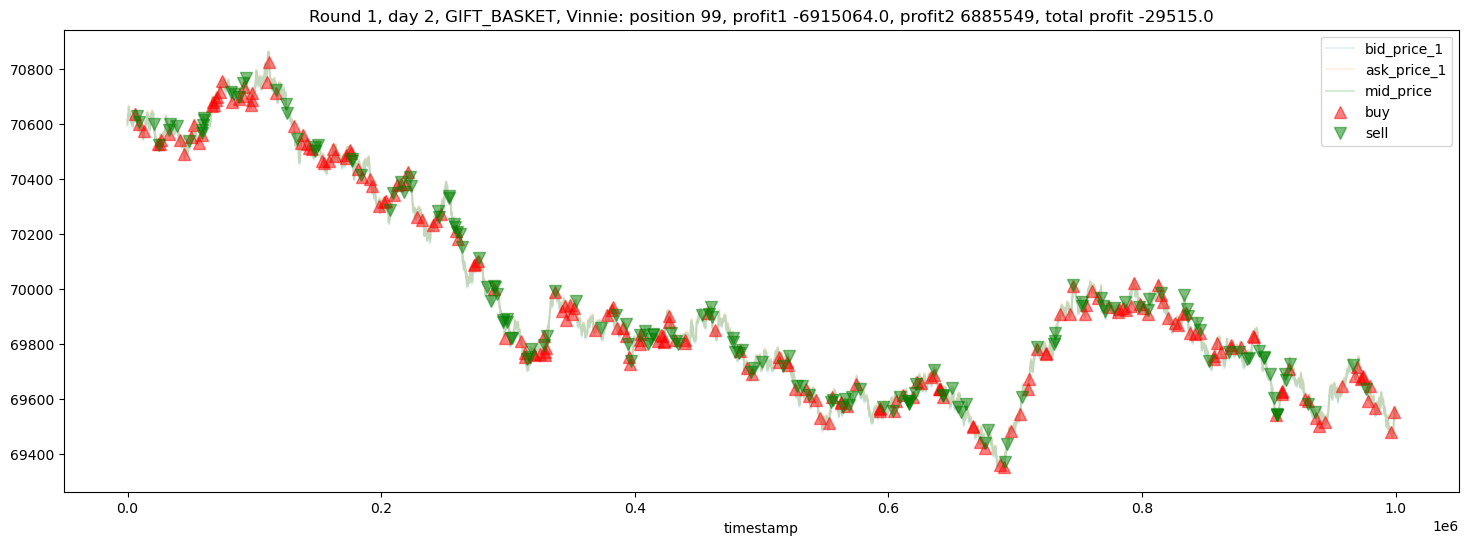

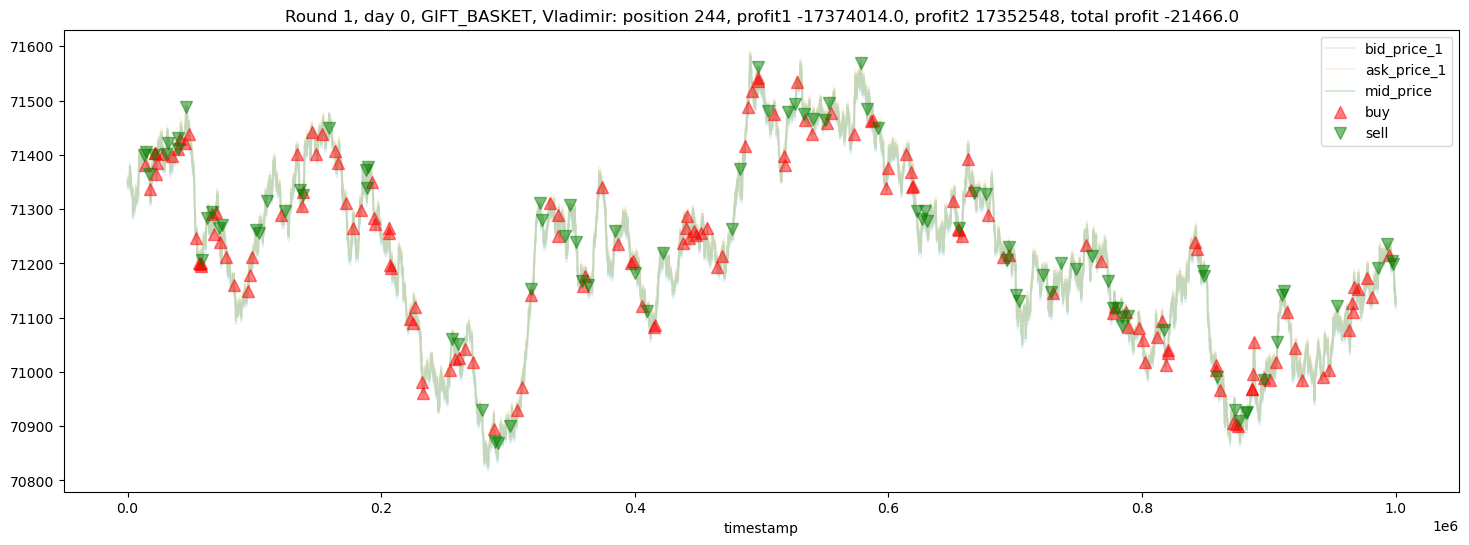

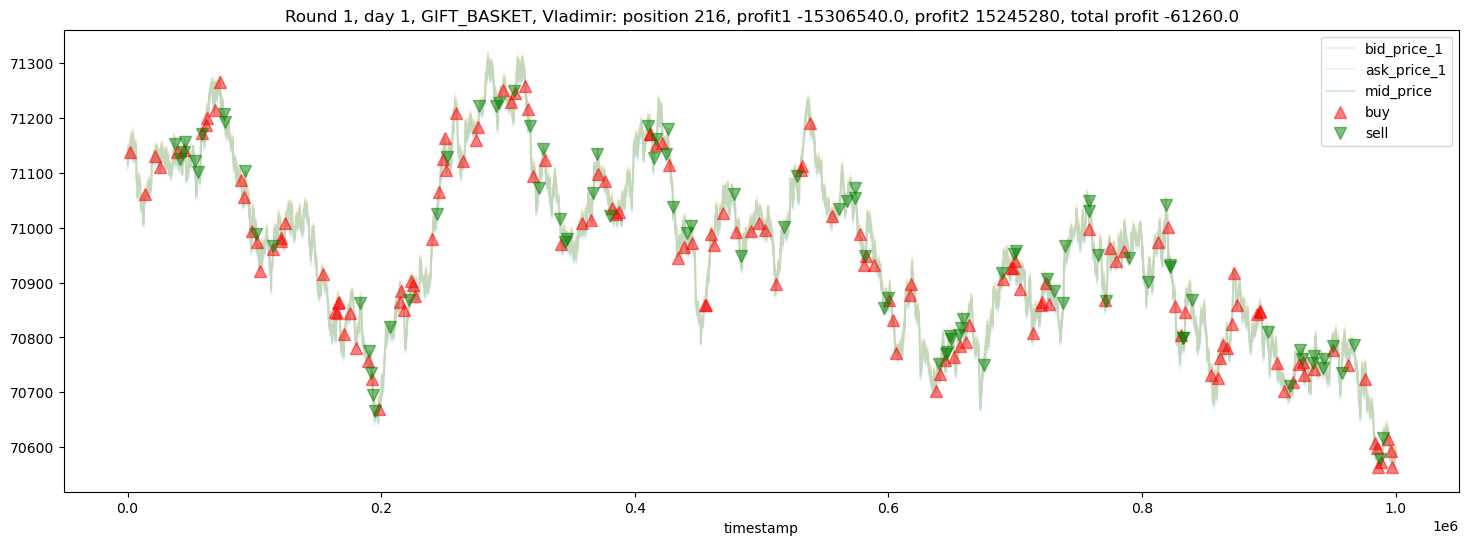

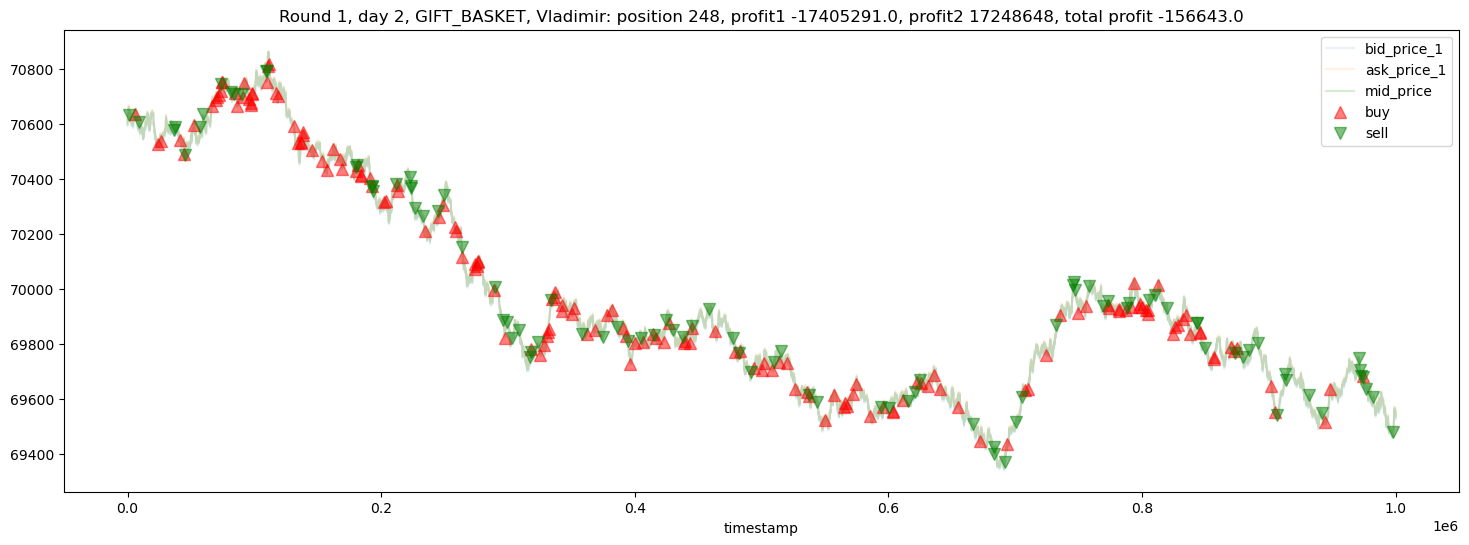

In [57]:
product = 'GIFT_BASKET'
sample = slice(0,1000_000)

plot_trade_on_price(sample, product, activity3, trade3)

## CHOCOLATE

In [ ]:
product = 'CHOCOLATE'
sample = slice(0,1000_000)

plot_trade_on_price(sample, product, activity3, trade3)

## STRAWBERRIES

In [ ]:
product = 'STRAWBERRIES'
sample = slice(0,1000_000)

plot_trade_on_price(sample, product, activity3, trade3)

## ROSES

In [ ]:
product = 'ROSES'
sample = slice(0,100_000)

plot_trade_on_price(sample, product, activity3, trade3)

# Round 4

## COCONUT_COUPON

In [ ]:
product = 'COCONUT_COUPON'
sample = slice(0,100_000)

plot_trade_on_price(sample, product, activity4, trade4)

## COCONUT

In [ ]:
product = 'COCONUT'
sample = slice(0,1000_000)

plot_trade_on_price(sample, product, activity4, trade4)